<a href="https://colab.research.google.com/github/dtabuena/Data_Explore/blob/main/MessingWithData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
!pip install openpyxl
!pip install XlsxWriter
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [77]:
link = 'https://www.dropbox.com/sh/5jheuv2n7pmfzw9/AABpo1PU8v33CR3CCxq3459ba?dl=0'
my_drop_folder = 'my_drop_folder'
zipped_file_path = "/content/"+my_drop_folder + ".zip"
unzipped_file_path = "/content/"+my_drop_folder
if not( os.path.exists(zipped_file_path)):
    !wget -O $zipped_file_path $link    # download with new name
!echo A | unzip $zipped_file_path -d $unzipped_file_path 
print(unzipped_file_path)

Archive:  /content/my_drop_folder.zip
mapname:  conversion of  failed
replace /content/my_drop_folder/CA3 parameters for PCA.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: /content/my_drop_folder/CA3 parameters for PCA.xlsx  
/content/my_drop_folder


In [78]:
my_df_dict  = pd.read_excel('my_drop_folder/CA3 parameters for PCA.xlsx', engine='openpyxl',index_col=0,sheet_name=None)
for k in my_df_dict.keys():
    print(k)

E4 9mo
E3 9mo
E4 19mo
E3 19mo
fE4 syncre+
fE4 syncre-


In [79]:
for k in my_df_dict.keys():
    df = my_df_dict[k]
    df['type'] = k
df_list = [my_df_dict[k] for k in my_df_dict.keys()]
full_df = pd.concat(df_list)

In [80]:
for r in full_df.index:
    if full_df.loc[r,'AP amp'] <60:
        full_df.at[r,'AP amp'] = np.nan

,Cm,Rin,RMP,I-F Gain,Rheobase,Spike Latency,Max Firing rate,AP threshold,fAHP(1),sAHP,AP width,AP amp,Adaptation Ratio,AP rise time,extra,type
20200227-05,-0.931103,1.796564,0.018204,-0.402004,-1.227478,-1.354918,-0.824384,0.234378,0.224157,-0.879581,3.068240,-0.193045,-0.117922,0.901183,1.0,E4 9mo
20200227-16,0.296052,0.183750,0.338122,-1.021312,0.272773,0.747849,-0.579769,0.081505,1.815558,-0.732227,2.016875,2.087643,-0.395120,0.332292,1.0,E4 9mo
20200227-23,-0.756246,1.972356,-1.016827,-1.131902,-0.477352,-0.414420,-1.313614,-0.158569,0.557797,-0.588210,2.320693,1.282571,-0.082750,0.458888,1.0,E4 9mo
20200305-01,-1.104259,2.264200,0.394578,0.438485,-1.227478,-1.790853,0.235614,-0.835380,0.103238,-0.968985,2.596801,1.819227,-0.113208,0.820563,0.0,E4 9mo
20200305-06,-0.667117,2.259204,-1.054464,0.748138,-1.227478,-1.430757,-0.253616,-0.740452,-0.186964,-0.835297,2.694438,1.561523,-0.281009,0.701092,0.0,E4 9mo


(145, 5)
Var exp: 0.7713294230870567


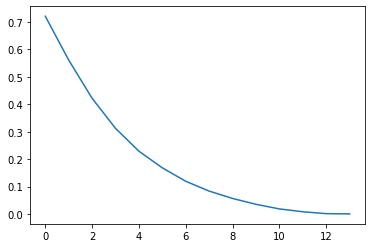

In [81]:
labeling = ['Cell','type','extra'] # non numerical data 
numericals = [c for c in full_df.columns if c not in labeling ]

full_df_norm = full_df.copy()
mean_dict = {}
sd_dict = {}

for c in full_df_norm.columns:
    if c not in labeling:
        col_mean = np.mean(full_df_norm[c])
        col_sd = np.std(full_df_norm[c])
        mean_dict[c] = col_mean
        sd_dict[c] = col_sd
        full_df_norm[c] = (full_df_norm[c] - col_mean)/col_sd


null_check = pd.isna(full_df_norm)
incomplete =[]
for r in full_df_norm.index:
    vals = np.array(null_check.loc[r,numericals])
    bad = any(vals)
    if bad:
        incomplete.append(r)
# print(incomplete)

complete = [c for c in  full_df_norm.index if c not in incomplete]
full_df_no_null = full_df_norm.loc[complete].copy()
display(full_df_no_null.head())



data_X = full_df_no_null[numericals].to_numpy()
data_X.shape
pca = PCA(n_components=min(data_X.shape))
data_X_enc = pca.fit_transform(data_X)
plt.plot(1-np.cumsum(pca.explained_variance_ratio_))
pca = PCA(n_components=5)
data_X_enc = pca.fit_transform(data_X)
print(data_X_enc.shape)
print('Var exp:' ,sum(pca.explained_variance_ratio_))
data_X_reduced = pca.inverse_transform(data_X_enc)



In [82]:


type_list = list(full_df_no_null['type'])
uniq_types = list(set(type_list))
uniq_types.sort()
print(uniq_types)
num_t = len(uniq_types)
type_num = [ uniq_types.index(t) for t in type_list]

colors = plt.cm.viridis(np.linspace(0,1,num_t))
alpha = .4
colors = [[0, 0, 0, 1], [0, 0, 0, alpha],
          [1, 0, 1, 1], [1, 0, 1, alpha], 
          [0, .8, .8, 1], [0, .8, .8, alpha]]

list_colors = [colors[i] for i in type_num ]

  

['E3 19mo', 'E3 9mo', 'E4 19mo', 'E4 9mo', 'fE4 syncre+', 'fE4 syncre-']


In [83]:
### use knn to define umap regions ###

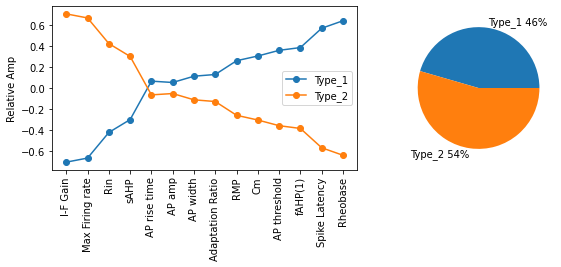

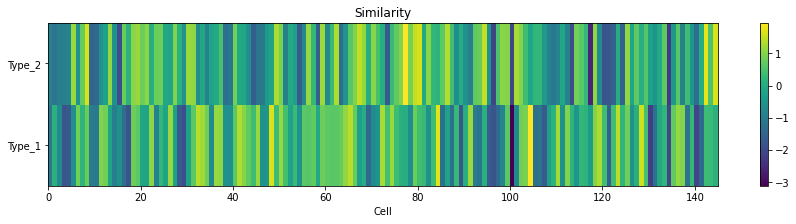

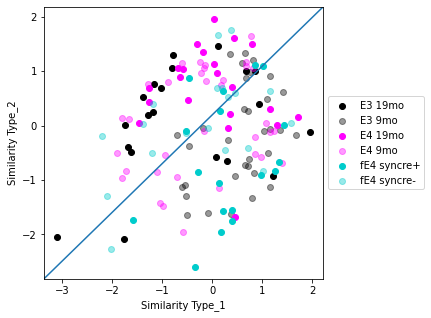

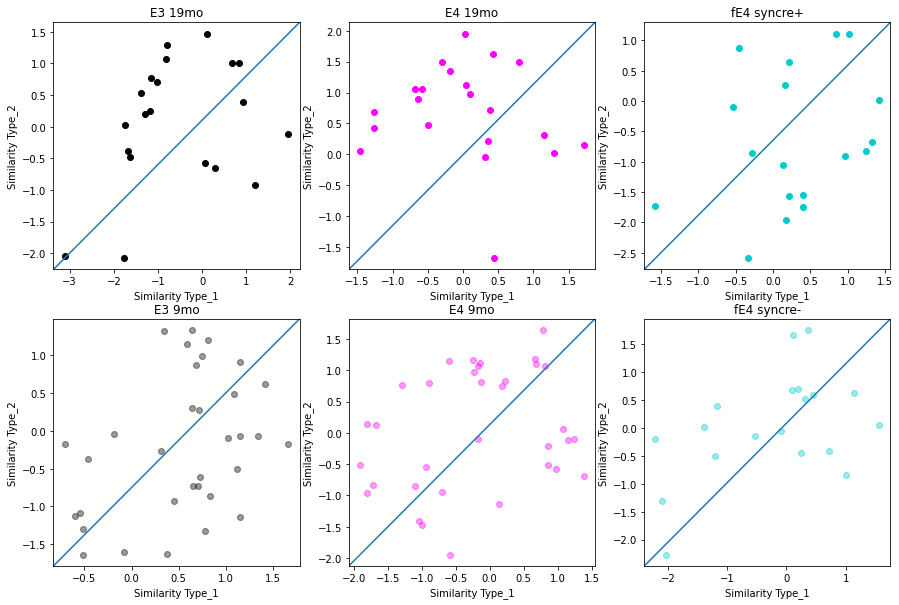

In [84]:
from sklearn.cluster import KMeans

data_for_fit = data_X_reduced
fig_opt = {'dpi': 300, 'format':'png'}

kmeans = KMeans(n_clusters=2, random_state=42).fit(data_for_fit)
centers = kmeans.cluster_centers_.T
distances = kmeans.transform(data_for_fit)

rel_centers = (centers.T - np.mean(centers.T,axis = 0)).T

new_cent_order = np.argsort(centers[:,0]).tolist()
fig, ax = plt.subplots(1,2,figsize = [9,3], gridspec_kw={'width_ratios': [2, 1]} )
ax[0].plot(rel_centers[new_cent_order,:],'-o')
ax[0].legend(['Type_1', 'Type_2'])
sorted_numericals = [numericals[i] for i in new_cent_order]
ax[0].set_xticks(np.arange(len(numericals)))
ax[0].set_xticklabels(sorted_numericals,rotation=90)
ax[0].set_ylabel('Relative Amp')
labels = kmeans.labels_ 
rel_counts = [np.mean( l == labels ) for l in range(2)]
# print(counts)
ax[1].pie( rel_counts, labels=['Type_1 '+str(round(rel_counts[0]*100))+'%', 'Type_2 '+str(round(rel_counts[1]*100))+'%']  )
fig.savefig('Clusters.'+fig_opt['format'],**fig_opt)




distances_norm = (distances - np.mean(distances,axis=0)) / (np.std(distances,axis=0))
closeness = -1 * (distances_norm) 
fig, ax = plt.subplots(1,figsize = [15,3])
c = ax.pcolor(closeness.T)
ax.set_xlabel('Cell')
ax.set_yticks(np.arange(2)+0.5)
ax.set_yticklabels(['Type_1', 'Type_2'])
ax.title.set_text('Similarity')
fig.colorbar(c, ax=ax)
fig.savefig('Cells_in_Clusters.'+fig_opt['format'],**fig_opt)

fig, ax = plt.subplots(1,figsize = [5,5])
for ti in range(num_t):
    t = uniq_types[ti]
    t_colr = colors[ti]
    is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
    ax.scatter(closeness[is_type,0],closeness[is_type,1],color=t_colr, label=t)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Similarity Type_1')
ax.set_ylabel('Similarity Type_2')
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
fig.savefig('GenoType_dist.'+fig_opt['format'],**fig_opt)

#### separate #####
fig, axs = plt.subplots(2,3,figsize = [15,10])
axs = axs.T.flatten()
for ti in range(num_t):
    t = uniq_types[ti]
    t_colr = colors[ti]
    is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
    axs[ti].scatter(closeness[is_type,0],closeness[is_type,1],color=t_colr, label=t)
    # axs[ti].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[ti].set_xlabel('Similarity Type_1')
    axs[ti].set_ylabel('Similarity Type_2')
    axs[ti].plot([0, 1], [0, 1], transform=axs[ti].transAxes)
    axs[ti].title.set_text(t)
fig.savefig('GenoType_dist_Separate.'+fig_opt['format'],**fig_opt)

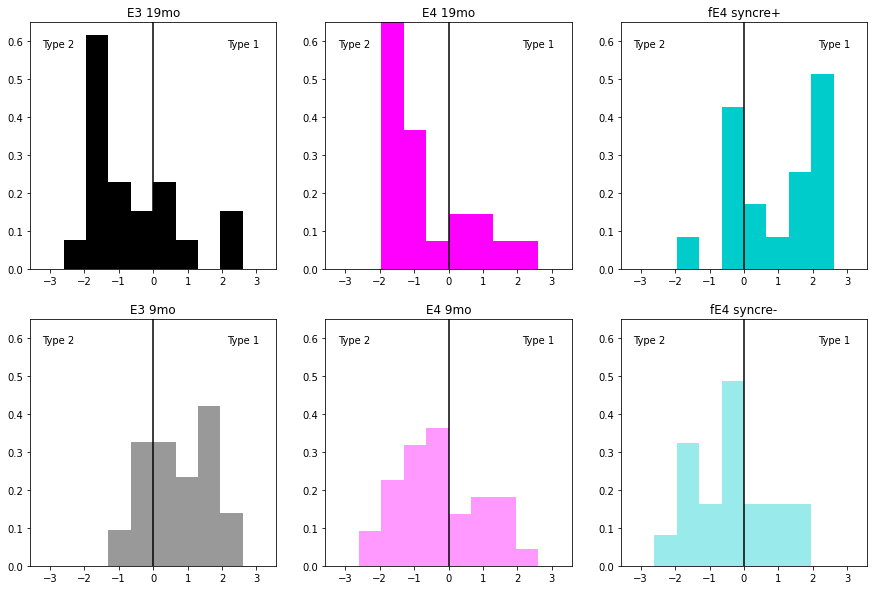

In [85]:
#### separate #####
fig, axs = plt.subplots(2,3,figsize = [15,10])
axs = axs.T.flatten()
for ti in range(num_t):
    t = uniq_types[ti]
    t_colr = colors[ti]
    is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]

    score = closeness[:,0] - closeness[:,1]

    axs[ti].hist(score[is_type],10,color=t_colr,histtype='bar',density=True,range=(-3.25,3.25))
    # axs[ti].set_xlabel('Similarity Type_1')
    # axs[ti].set_ylabel('Similarity Type_2')
    # axs[ti].plot([0, 1], [0, 1], transform=axs[ti].transAxes)
    axs[ti].title.set_text(t)
    axs[ti].axvline(0, color='k') # vertical
    axs[ti].set_ylim(0,0.65)
    axs[ti].text(.8, .9, 'Type 1',transform=axs[ti].transAxes)
    axs[ti].text(.05, .9, 'Type 2',transform=axs[ti].transAxes)
fig.savefig('GenoType_Histos.'+fig_opt['format'],**fig_opt)

In [92]:
import os
from google import colab
for root, dirs, files in os.walk("/content"):
    for f in files:
        if f.endswith(".png"):
             colab.files.download(os.path.join(root, f))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [87]:

# ####################################  TSNE ###############################################
# from sklearn.manifold import TSNE

# fig, axs = plt.subplots(2,3, figsize=[18,12])
# axs = axs.flatten()
# perp_list = [2, 5, 10 , 50, 100, 300]
# for p in perp_list:
#     p_i = perp_list.index(p)
#     X_embedded  = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=p,n_iter=1000).fit_transform(data_X)
#     for ti in range(num_t):
#         t = uniq_types[ti]
#         t_colr = colors[ti]
#         is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
#         axs[p_i].scatter(X_embedded[is_type,0],X_embedded[is_type,1],color=t_colr, label=t)
#         axs[p_i].legend( loc='upper left', ncol=1)
#     axs[p_i].set_title = p
# plt.show()

In [88]:

# ####################################  UMAP ###############################################
# import umap

# u_embedding = umap.UMAP(random_state=42).fit_transform(data_X)
# fig, axs = plt.subplots(1)
# n_list = [2, 5, 10, 30, 50, 100]
# for ni in range(len(n_list)):
#     t = uniq_types[ni]
#     t_colr = colors[ni]
#     is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ni]
#     axs.scatter(u_embedding[is_type,0],u_embedding[is_type,1],color=t_colr, label=t)
# axs.legend(bbox_to_anchor=(1.5, 1), loc='upper right', ncol=1)
# plt.show()




# u_embs = {}
# for n in n_list:
#     u_embs[n] = umap.UMAP(n_neighbors=n,random_state=42).fit_transform(data_X)



# fig, axs = plt.subplots(2,3,figsize=[18,12])
# axs = axs.flatten()
# for n in n_list:
#     i = n_list.index(n)
#     # axs[i].scatter(u_embs[n][:,0], u_embs[n][:,1],color=list_colors)
#     for ti in range(num_t):
#         t = uniq_types[ti]
#         t_colr = colors[ti]
#         is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
#         axs[i].scatter(u_embs[n][is_type,0],u_embs[n][is_type,1],color=t_colr, label=t)
#     axs[i].legend(bbox_to_anchor=(1.5, 1), loc='upper right', ncol=1)
# plt.show()
# print(uniq_types)
